In [54]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA


In [3]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27031 entries, 0 to 27030
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27031 non-null  datetime64[ns]
 1   Open       27031 non-null  float64       
 2   High       27031 non-null  float64       
 3   Low        27031 non-null  float64       
 4   Close      27031 non-null  float64       
 5   Adj Close  27031 non-null  float64       
 6   Volume     27031 non-null  int64         
 7   Ticker     27031 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.6+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [4]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001


In [5]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.30
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA,-0.026404,0.512961,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA,-0.013185,0.503460,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA,0.003296,0.497799,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA,0.009889,0.496803,1.0


In [6]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA,-0.026404,0.512961,-1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA,-0.013185,0.503460,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA,0.003296,0.497799,1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA,0.009889,0.496803,1.0,0.494478,-1.0


In [7]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-10)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-10)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [8]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.497743
5738,2025-01-09,11.430000,11.510000,11.300000,11.400000,11.400000,24470100,ABEV3.SA,-0.020000,11.508588,NaN,11.400000,NaN,NaN,NaN
5739,2025-01-10,11.400000,11.430000,11.080000,11.160000,11.160000,31277300,ABEV3.SA,-0.240000,11.404012,NaN,11.160000,NaN,NaN,NaN
5740,2025-01-13,11.180000,11.310000,11.120000,11.240000,11.240000,28945300,ABEV3.SA,0.080000,11.354808,NaN,11.240000,NaN,NaN,NaN
5741,2025-01-14,11.210000,11.370000,11.150000,11.210000,11.210000,42625300,ABEV3.SA,-0.030000,11.311366,NaN,11.210000,NaN,NaN,NaN
5742,2025-01-15,11.300000,11.430000,11.160000,11.390000,11.390000,45380700,ABEV3.SA,0.180000,11.334956,NaN,11.390000,NaN,NaN,NaN
5743,2025-01-16,11.420000,11.420000,11.040000,11.080000,11.080000,29298500,ABEV3.SA,-0.310000,11.258469,NaN,11.080000,NaN,NaN,NaN
5744,2025-01-17,10.840000,11.090000,10.770000,11.090000,11.090000,51433600,ABEV3.SA,0.010000,11.207929,NaN,11.090000,NaN,NaN,NaN
5745,2025-01-20,11.050000,11.110000,10.790000,11.050000,11.050000,22293700,ABEV3.SA,-0.040000,11.160550,NaN,11.050000,NaN,NaN,NaN
5746,2025-01-21,10.990000,11.260000,10.990000,11.250000,11.250000,26293900,ABEV3.SA,0.200000,11.187385,NaN,11.250000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [9]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [10]:
n = 14
low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [11]:
# Período de cálculo do indicador
n = 14

low_14, high_14 = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_14 = low_14.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculando o indicador
r_percent = ((high_14 - price_data['Smoothed_Close']) / (high_14 - low_14)) * (- 100)


price_data['r_percent'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [12]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [13]:
# Período do indicador
n = 20

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = n))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085,-0.090435
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784,-0.070905
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965,-0.059487
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306,-0.046286
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440,-0.038824


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [14]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11773,2025-01-16,52.290001,53.270000,52.000000,52.669998,52.669998,220262800,VALE3.SA,0.070000,52.266431,NaN,52.669998,NaN,NaN,NaN,0.000000,0.070000,45.877603,50.869999,55.400002,30.826305,-69.173695,-1.545152,-1.468085,-0.090435,358458862
11774,2025-01-17,53.150002,54.490002,52.980000,54.490002,54.490002,54658700,VALE3.SA,1.820004,52.933502,NaN,54.490002,NaN,NaN,NaN,0.000000,1.820004,67.345288,50.869999,55.189999,47.766288,-52.233712,-1.436582,-1.461784,-0.070905,413117562
11775,2025-01-20,54.220001,54.490002,53.759998,54.290001,54.290001,12317600,VALE3.SA,-0.200001,53.340452,NaN,54.290001,NaN,NaN,NaN,0.200001,0.000000,64.120420,50.869999,55.189999,57.186417,-42.813583,-1.302685,-1.429965,-0.059487,425435162
11776,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.544317,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,63.222645,-36.777355,-1.166672,-1.377306,-0.046286,454233862
11777,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.279022,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,66.547535,-33.452465,-1.067977,-1.315440,-0.038824,419588462


#### Salvando antes de tirar os Nans.

In [15]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [22]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [16]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27031 linhas e 26 colunas
Depois da retirada dos NaN temos 26881 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11763,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.664059,-1.0,54.250000,-1.0,52.669998,52.266431,0.299999,0.0,32.709994,53.330002,59.939999,20.182416,-79.817584,-1.161412,-0.997203,-0.059190,288773962
11764,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,54.236842,-1.0,53.240002,1.0,54.490002,52.933502,1.009998,0.0,25.572295,52.880001,59.590000,20.221175,-79.778825,-1.197801,-1.037322,-0.070463,265165262
11765,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,53.733790,-1.0,52.560001,1.0,54.290001,53.340452,0.680000,0.0,21.865682,52.480000,57.680000,24.111344,-75.888656,-1.252790,-1.080416,-0.079661,243475762
11766,2025-01-07,52.630001,52.889999,51.939999,52.049999,52.049999,22070200,VALE3.SA,-0.510002,53.228652,1.0,52.049999,1.0,54.020000,53.544317,0.510002,0.0,19.428651,51.939999,56.709999,27.015802,-72.984198,-1.321892,-1.128711,-0.083345,221405562
11767,2025-01-08,52.029999,52.290001,51.430000,51.549999,51.549999,24423800,VALE3.SA,-0.500000,52.725057,1.0,51.549999,1.0,52.660000,53.279022,0.500000,0.0,17.253360,51.430000,56.540001,25.343563,-74.656437,-1.401140,-1.183197,-0.090757,196981762


## VALIDAÇÃO

### Geral

In [436]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data['Prediction']

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.5193296089385475

Fold 2:
Accuracy for fold 2: 0.5432402234636872

Fold 3:
Accuracy for fold 3: 0.5374301675977654

Fold 4:
Accuracy for fold 4: 0.5796648044692737

Fold 5:
Accuracy for fold 5: 0.5897206703910615

                precision    recall  f1-score      support  accuracy
1 Down Day       0.488971  0.570815  0.526733  2097.000000  0.519330
  Up Day         0.555994  0.473928  0.511691  2378.000000  0.519330
  accuracy       0.519330  0.519330  0.519330     0.519330  0.519330
  macro avg      0.522482  0.522372  0.519212  4475.000000  0.519330
  weighted avg   0.524587  0.519330  0.518740  4475.000000  0.519330
2 Down Day       0.503810  0.577110  0.537975  2062.000000  0.543240
  Up Day         0.587317  0.514298  0.548387  2413.000000  0.543240
  accuracy       0.543240  0.543240  0.543240     0.543240  0.543240
  macro avg      0.545563  0.545704  0.543181  4475.000000  0.543240
  weighted avg   0.548838  0.543240  0.543589  4475.000000  0.543

In [437]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  68.59824221659466


In [438]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 79.59%


In [439]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [17]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,11.995998,-1.0,11.60,-1.0,11.08,11.258469,0.139999,0.00,17.590948,11.49,14.50,16.810569,-83.189431,-0.190249,-0.014482,-0.046127,-2740522273
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,11.796199,-1.0,11.33,-1.0,11.09,11.207929,0.270000,0.00,14.655374,11.27,14.36,17.029069,-82.970931,-0.247106,-0.061007,-0.076855,-2781888173
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,11.644339,-1.0,11.29,-1.0,11.05,11.160550,0.040000,0.00,14.248904,11.21,13.58,18.326538,-81.673462,-0.300950,-0.108995,-0.111105,-2832769673
5736,2025-01-07,11.30,11.58,11.27,11.54,11.54,34905200,ABEV3.SA,0.250000,11.613037,-1.0,11.54,-1.0,11.25,11.187385,0.000000,0.25,28.541568,11.21,13.42,18.236978,-81.763022,-0.342203,-0.155637,-0.130035,-2867674873
5737,2025-01-08,11.48,11.53,11.28,11.42,11.42,39248800,ABEV3.SA,-0.120000,11.555126,-1.0,11.42,-1.0,11.02,11.137170,0.120000,0.00,26.129481,11.21,13.42,15.616564,-84.383436,-0.375243,-0.199558,-0.154721,-2906923673


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [84]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0, max_depth= 2)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")



Fold 1:


  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.56
Fold 2:
  Accuracy with Y_test (Prediction): 0.66
  Accuracy with Verify: 0.61
Fold 3:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.47
Fold 4:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.56
Fold 5:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.45

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.57
  Média da acurácia com Verify: 0.53


#### Plotagem Time-Series Cross Validation

In [ ]:
# Cálculo individual de métricas
acuracia = accuracy_score(y_true, y_pred)
precisao = precision_score(y_true, y_pred, average='binary')  # Para classificações binárias
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print("Acurácia:", acuracia)
print("Precisão:", precisao)
print("Recall:", recall)
print("F1-Score:", f1)

# Relatório completo
print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

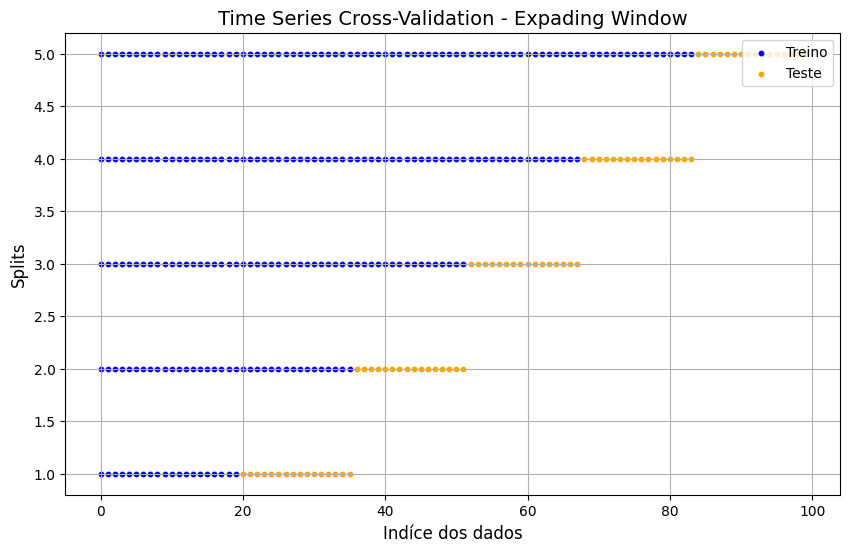

In [19]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Treino" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Teste" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Indíce dos dados", fontsize=12)
    ax.set_ylabel("Splits", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation - Expading Window"
)


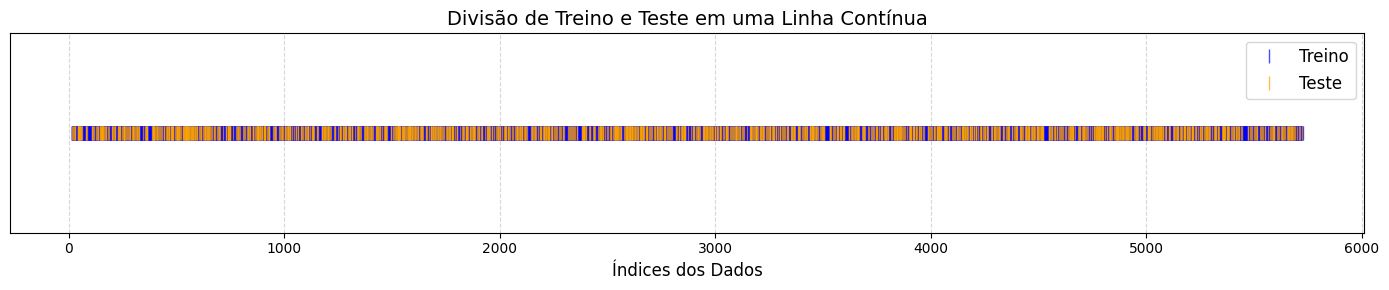

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Supondo que price_data_ABEV já esteja carregado como DataFrame
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar um vetor que represente a sequência de todos os dados
data_size = len(price_data_ABEV)
data_indices = np.arange(data_size)

# Criar uma máscara para marcar treino e teste
is_train = np.isin(data_indices, X_train.index)
is_test = np.isin(data_indices, X_test.index)

# Criar o gráfico com uma linha contínua
plt.figure(figsize=(14, 3))

# Destacar treino
plt.plot(data_indices[is_train], np.ones(sum(is_train)), '|', color='blue', label='Treino', markersize=10, alpha=0.7)

# Destacar teste
plt.plot(data_indices[is_test], np.ones(sum(is_test)), '|', color='orange', label='Teste', markersize=10, alpha=0.7)

# Configurações do gráfico
plt.title('Divisão de Treino e Teste em uma Linha Contínua', fontsize=14)
plt.xlabel('Índices dos Dados', fontsize=12)
plt.yticks([])
plt.legend(loc='upper right', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


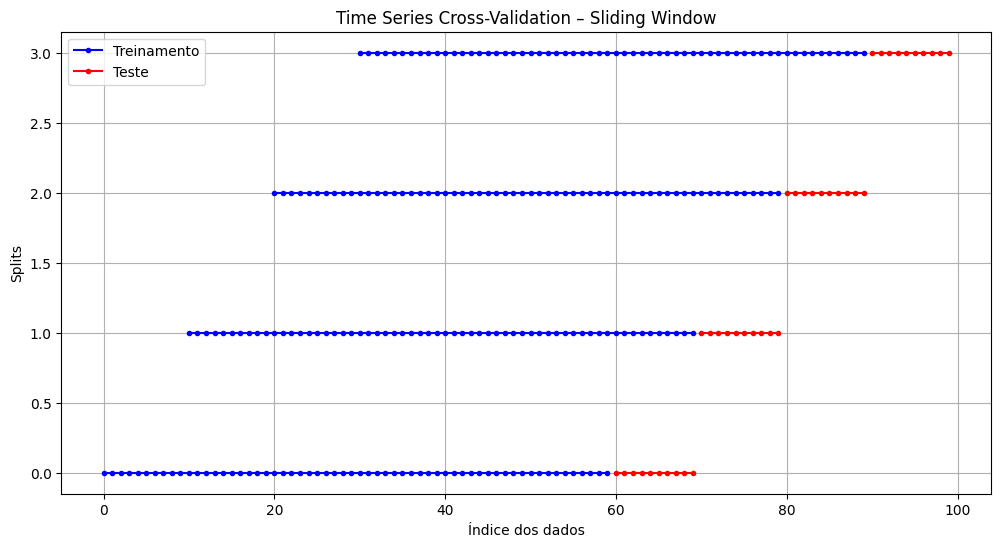

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Configurando os dados fictícios
n_observations = 100  # Total de observações (dados)
n_train = 60          # Tamanho do conjunto de treinamento inicial
n_test = 10           # Tamanho do conjunto de teste por janela

# Gerando índices fictícios
indices = np.arange(n_observations)

# Inicializando variáveis
train_windows = []
test_windows = []

# Criando janelas de validação Walk-Forward
for start in range(0, n_observations - n_train - n_test + 1, n_test):
    train_window = indices[start : start + n_train]
    test_window = indices[start + n_train : start + n_train + n_test]
    train_windows.append(train_window)
    test_windows.append(test_window)

# Plotando Walk-Forward Validation
plt.figure(figsize=(12, 6))
for i, (train, test) in enumerate(zip(train_windows, test_windows)):
    plt.plot(train, [i] * len(train), 'b.-', label='Treinamento' if i == 0 else "")
    plt.plot(test, [i] * len(test), 'r.-', label='Teste' if i == 0 else "")

# Configurando o gráfico
plt.xlabel('Índice dos dados')
plt.ylabel('Splits')
plt.title('Time Series Cross-Validation – Sliding Window')
plt.legend()
plt.grid(True)
plt.show()


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_ABEV):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [85]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [86]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.51
Window 2:
  Accuracy with Y_test (Prediction): 0.50
  Accuracy with Verify: 0.48
Window 3:
  Accuracy with Y_test (Prediction): 0.66
  Accuracy with Verify: 0.61
Window 4:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.57
Window 5:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.50
Window 6:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.44
Window 7:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.48
Window 8:
  Accuracy with Y_test (Prediction): 0.49
  Accuracy with Verify: 0.47
Window 9:
  Accuracy with Y_test (Prediction): 0.32
  Accuracy with Verify: 0.35
Window 10:
  Accuracy with Y_test (Prediction): 0.44
  Accuracy with Verify: 0.45
Window 11:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.52
Window 12:
  Accuracy with Y_test (Prediction): 0.62
  Accuracy with Verify: 0.56
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [87]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

In [88]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0, max_depth= None, max_samples=None, max_leaf_nodes=None)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Ambev.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Ambev.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  77.2027972027972


In [89]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.759857,0.688312,0.722317,616.000000
Up Day,0.779817,0.835381,0.806643,814.000000
accuracy,0.772028,0.772028,0.772028,0.772028
macro avg,0.769837,0.761846,0.764480,1430.000000
weighted avg,0.771218,0.772028,0.770318,1430.000000


Accuracy: 0.772027972027972
Precision: 0.7798165137614679
Recall: 0.8353808353808354
Specificity: 0.6883116883116883


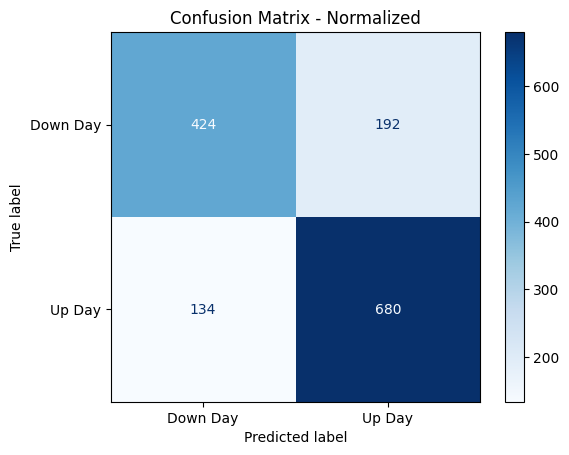

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


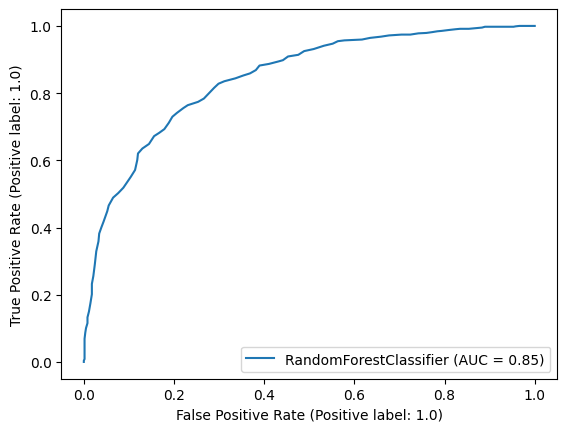

In [91]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)
from sklearn.model_selection import train_test_split

# Definição das colunas de entrada e saída
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 
                          'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']
verify = price_data_ABEV['Verify']  # Adicionando a verificação com o preço real

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test, y_verify_train, y_verify_test = train_test_split(
    X_Cols, Y_Cols, verify, random_state=0
)

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=80, oob_score=True, 
                                             criterion="gini", random_state=0, max_depth=None)

# Treinando o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazendo predições para os dois conjuntos de dados
y_pred = rand_frst_clf_Ambev.predict(X_test)  # Previsão com os preços suavizados
y_pred_verify = rand_frst_clf_Ambev.predict(X_test)  # Previsão com os preços reais

# Cálculo das métricas para ambos os conjuntos
def calcular_metricas(y_true, y_pred, label):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = confusion_matrix(y_true, y_pred)[0, 0] / sum(confusion_matrix(y_true, y_pred)[0])
    f1 = f1_score(y_true, y_pred)

    print(f'\nMétricas para {label}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  Specificity: {specificity:.4f}')
    print(f'  F1-Score: {f1:.4f}')

# Calculando métricas para ambos os conjuntos
calcular_metricas(y_test, y_pred, 'Y_Test (Prediction)')
calcular_metricas(y_verify_test, y_pred_verify, 'Verify (Preço Real)')

# Exibindo matriz de confusão para ambos os conjuntos
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down Day', 'Up Day'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred, 'Confusion Matrix - Y_Test (Prediction)')
plot_confusion_matrix(y_verify_test, y_pred_verify, 'Confusion Matrix - Verify (Preço Real)')

# Exibindo Curva ROC para ambos os conjuntos
def plot_roc_curve(y_true, title):
    RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_true)
    plt.title(title)
    plt.show()

plot_roc_curve(y_test, 'ROC Curve - Y_Test (Prediction)')
plot_roc_curve(y_verify_test, 'ROC Curve - Verify (Preço Real)')


In [ ]:
# Grab our X & Y Columns.
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']  # Target variable for training with smoothed prices
y_verify = price_data_ABEV['Verify']  # Direction of the real price

# Split X and y into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Create a Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=80, oob_score=True, criterion="gini", random_state=0)

# Fit the data to the model
rand_frst_clf_Ambev.fit(X_train, y_train)

# Make predictions with smoothed price direction (Prediction)
y_pred = rand_frst_clf_Ambev.predict(X_test)

# Calculate accuracy based on smoothed price direction ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print results
print(f'Acurácia with Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia with Verify: {accuracy_verify:.4f}')


In [ ]:

# Adicionando as previsões e os valores de y_test e y_verify ao DataFrame original
price_data_ABEV['Predictions'] = pd.Series(index=y_test.index, data=y_pred)
price_data_ABEV['Y_Test'] = pd.Series(index=y_test.index, data=y_test)
price_data_ABEV['Y_Verify'] = pd.Series(index=y_test.index, data=y_verify.loc[y_test.index])

price_data_ABEV.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/predictions_comparison.xlsx', index=False)


#### Salvar modelo aprendido para AMBEV.

In [449]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [67]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.56%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [ ]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

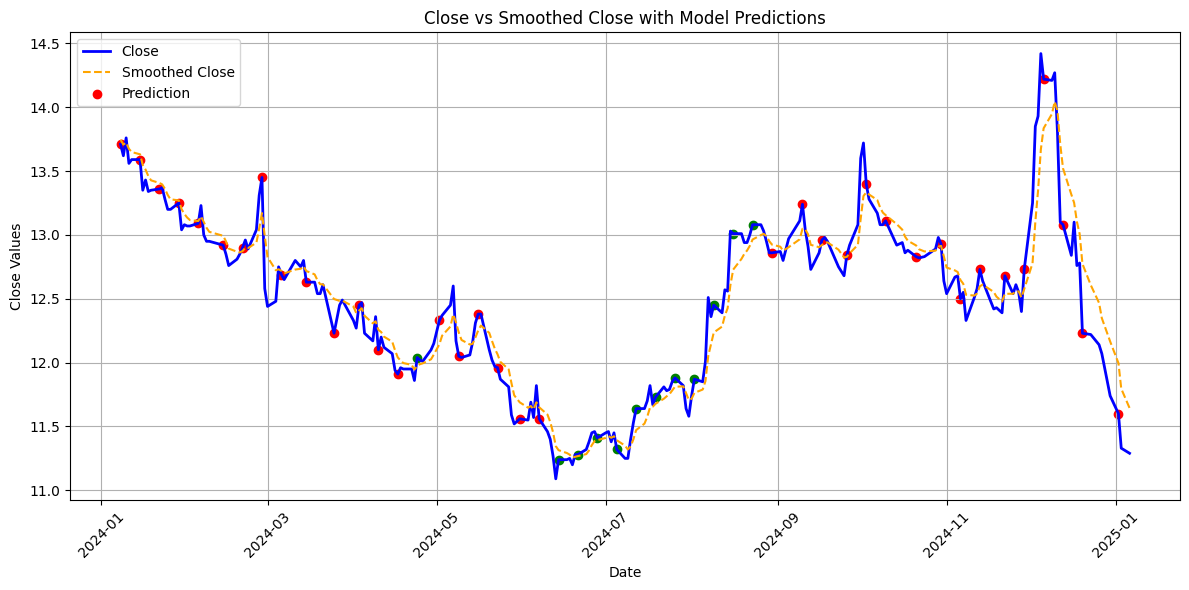

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0, max_depth=2)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 5):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [98]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17860,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.757917,49788916,ITUB4.SA,-0.049343,3.095684,1.0,3.080100,1.0,3.129443,3.160325,0.049343,0.000000,54.433299,2.790006,3.228790,69.664873,-30.335127,0.021286,-0.003548,0.048600,553645804
17861,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.776630,7959945,ITUB4.SA,0.032785,3.100845,1.0,3.112885,-1.0,3.079769,3.136158,0.000000,0.032785,59.382961,2.790006,3.228790,70.840896,-29.159104,0.021952,0.001552,0.049105,561605749
17862,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.786080,26138577,ITUB4.SA,0.016558,3.109424,1.0,3.129443,-1.0,3.088048,3.121725,0.000000,0.016558,61.800980,2.790006,3.228790,72.796190,-27.203810,0.022702,0.005782,0.038908,587744326
17863,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.800254,52977726,ITUB4.SA,0.024837,3.122881,-1.0,3.154280,-1.0,3.030096,3.094236,0.000000,0.024837,65.369227,2.831401,3.228790,73.348723,-26.651277,0.023825,0.009391,0.029324,640722052
17864,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.861679,141660459,ITUB4.SA,0.107626,3.164588,-1.0,3.261906,-1.0,3.046653,3.079961,0.000000,0.107626,76.394363,2.864351,3.261906,75.520973,-24.479027,0.027022,0.012917,0.031654,782382511


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [99]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.54
  Accuracy with Verify: 0.54
Fold 2:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.48
Fold 3:
  Accuracy with Y_test (Prediction): 0.50
  Accuracy with Verify: 0.46
Fold 4:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.56
Fold 5:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.55

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.53
  Média da acurácia com Verify: 0.52

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4840        -1.0             -1.0    -1.0
4841        -1.0             -1.0     1.0
4842        -1.0              1.0     1.0
4843        -1.0              1.0     1.0
4844        -1.0    

#### Plotagem Time-Series Cross Validation

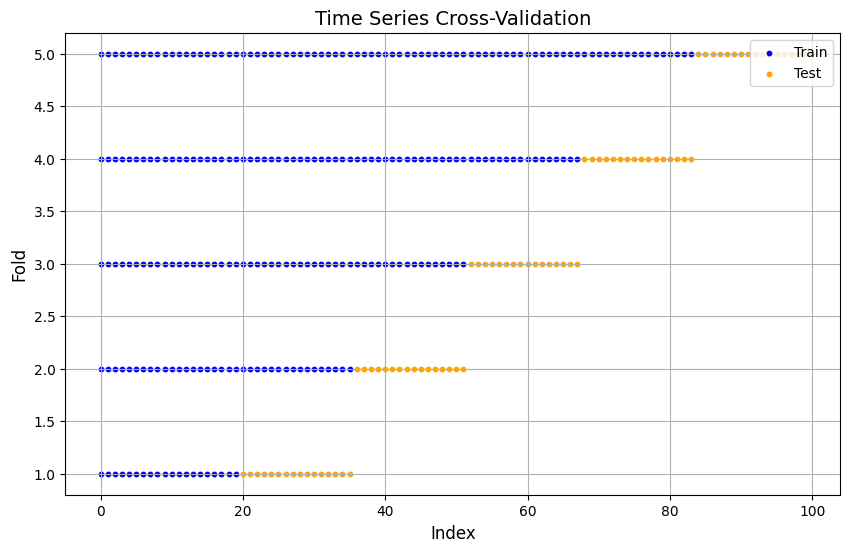

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Itau):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [83]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17860,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.757917,49788916,ITUB4.SA,-0.049343,3.095684,1.0,3.080100,1.0,3.129443,3.160325,0.049343,0.000000,54.433299,2.790006,3.228790,69.664873,-30.335127,0.021286,-0.003548,0.048600,553645804
17861,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.776630,7959945,ITUB4.SA,0.032785,3.100845,1.0,3.112885,-1.0,3.079769,3.136158,0.000000,0.032785,59.382961,2.790006,3.228790,70.840896,-29.159104,0.021952,0.001552,0.049105,561605749
17862,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.786080,26138577,ITUB4.SA,0.016558,3.109424,1.0,3.129443,-1.0,3.088048,3.121725,0.000000,0.016558,61.800980,2.790006,3.228790,72.796190,-27.203810,0.022702,0.005782,0.038908,587744326
17863,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.800254,52977726,ITUB4.SA,0.024837,3.122881,-1.0,3.154280,-1.0,3.030096,3.094236,0.000000,0.024837,65.369227,2.831401,3.228790,73.348723,-26.651277,0.023825,0.009391,0.029324,640722052
17864,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.861679,141660459,ITUB4.SA,0.107626,3.164588,-1.0,3.261906,-1.0,3.046653,3.079961,0.000000,0.107626,76.394363,2.864351,3.261906,75.520973,-24.479027,0.027022,0.012917,0.031654,782382511


In [84]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.48
Window 2:
  Accuracy with Y_test (Prediction): 0.41
  Accuracy with Verify: 0.45
Window 3:
  Accuracy with Y_test (Prediction): 0.41
  Accuracy with Verify: 0.39
Window 4:
  Accuracy with Y_test (Prediction): 0.64
  Accuracy with Verify: 0.67
Window 5:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.48
Window 6:
  Accuracy with Y_test (Prediction): 0.39
  Accuracy with Verify: 0.42
Window 7:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.51
Window 8:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.60
Window 9:
  Accuracy with Y_test (Prediction): 0.46
  Accuracy with Verify: 0.47
Window 10:
  Accuracy with Y_test (Prediction): 0.33
  Accuracy with Verify: 0.36
Window 11:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.54
Window 12:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.47
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [91]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17860,2001-01-12,3.129443,3.129443,3.046653,3.080100,1.757917,49788916,ITUB4.SA,-0.049343,3.095684,1.0,3.080100,1.0,3.129443,3.160325,0.049343,0.000000,54.433299,2.790006,3.228790,69.664873,-30.335127,0.021286,-0.003548,0.048600,553645804
17861,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.776630,7959945,ITUB4.SA,0.032785,3.100845,1.0,3.112885,-1.0,3.079769,3.136158,0.000000,0.032785,59.382961,2.790006,3.228790,70.840896,-29.159104,0.021952,0.001552,0.049105,561605749
17862,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.786080,26138577,ITUB4.SA,0.016558,3.109424,1.0,3.129443,-1.0,3.088048,3.121725,0.000000,0.016558,61.800980,2.790006,3.228790,72.796190,-27.203810,0.022702,0.005782,0.038908,587744326
17863,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.800254,52977726,ITUB4.SA,0.024837,3.122881,-1.0,3.154280,-1.0,3.030096,3.094236,0.000000,0.024837,65.369227,2.831401,3.228790,73.348723,-26.651277,0.023825,0.009391,0.029324,640722052
17864,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.861679,141660459,ITUB4.SA,0.107626,3.164588,-1.0,3.261906,-1.0,3.046653,3.079961,0.000000,0.107626,76.394363,2.864351,3.261906,75.520973,-24.479027,0.027022,0.012917,0.031654,782382511


In [92]:
# Grab our X & Y Columns.
X_Cols = price_data_Itau[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Itau.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Itau.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Itau.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  71.61512027491409


In [93]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.689655,0.671756,0.680588,655.000000
Up Day,0.736842,0.752500,0.744589,800.000000
accuracy,0.716151,0.716151,0.716151,0.716151
macro avg,0.713249,0.712128,0.712588,1455.000000
weighted avg,0.715600,0.716151,0.715777,1455.000000


Accuracy: 0.7161512027491409
Precision: 0.7368421052631579
Recall: 0.7525
Specificity: 0.6717557251908397


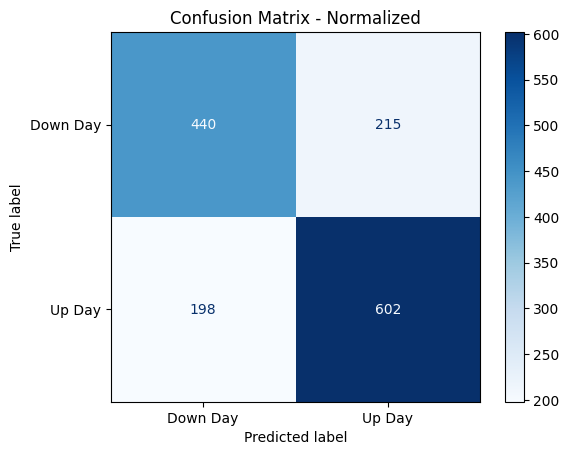

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


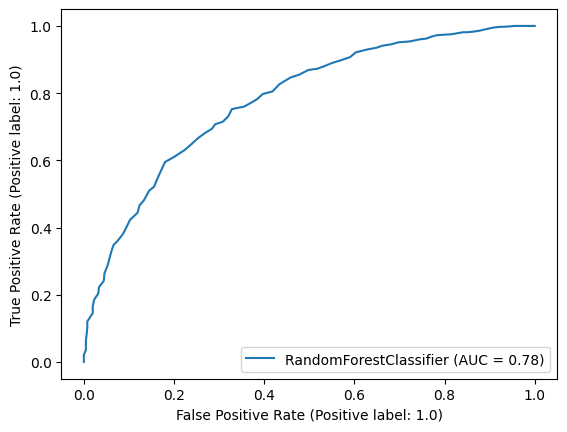

In [96]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para ITAU.

In [469]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [97]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 81.02%

Precisão do modelo nos últimos 30 dias: 89.47%


#### Plotagem:

In [ ]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

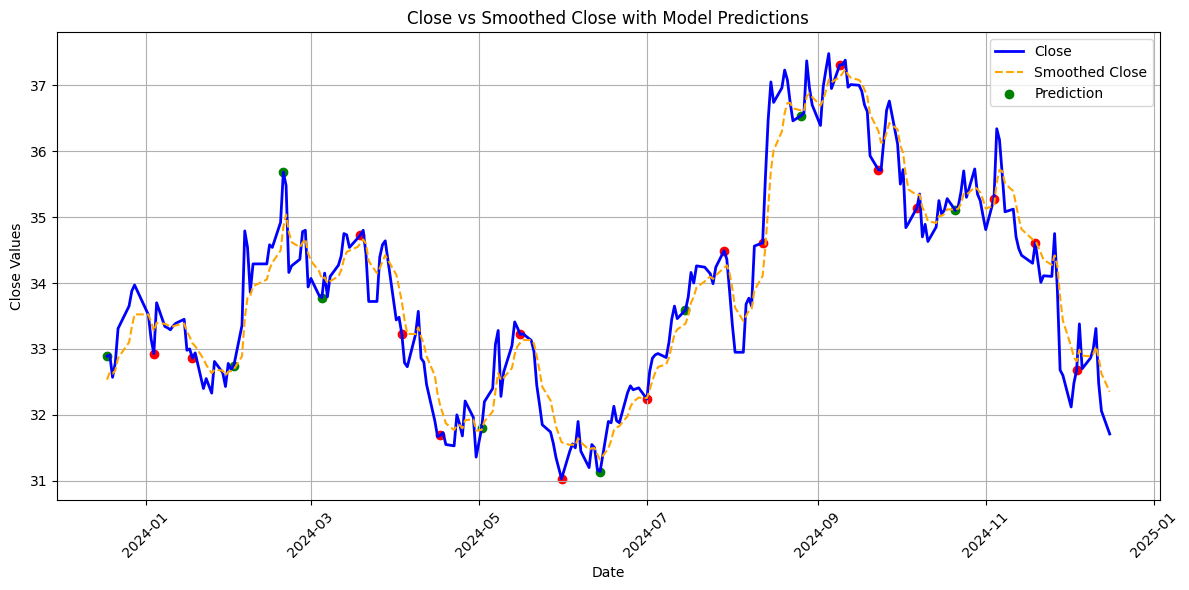

In [471]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Itau.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [103]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
23701,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274923,935719,MGLU3.SA,-0.017537,4.668414,1.0,4.641542,1.0,4.881218,4.793972,0.017537,0.000000,32.626397,4.533395,4.878295,39.147243,-60.852757,-0.015200,-0.035350,-0.024154,-13212506
23702,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218391,3585840,MGLU3.SA,-0.061381,4.641938,1.0,4.580161,1.0,4.878295,4.819269,0.061381,0.000000,25.316822,4.533395,4.878295,31.470881,-68.529119,-0.018632,-0.032007,-0.024912,-16798346
23703,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091865,1985366,MGLU3.SA,-0.137376,4.582192,1.0,4.442785,1.0,4.846144,4.827331,0.137376,0.000000,16.037903,4.439862,4.822760,37.171802,-62.828198,-0.024626,-0.030531,-0.039459,-18783712
23704,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234543,1263135,MGLU3.SA,0.154913,4.586844,1.0,4.597698,1.0,4.998134,4.878572,0.000000,0.154913,43.149183,4.436940,4.822760,38.853271,-61.146729,-0.028604,-0.030145,-0.040231,-17520577
23705,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.596238,1.0,4.618158,1.0,5.012748,4.918825,0.000000,0.020460,45.815425,4.436940,4.822760,41.288139,-58.711861,-0.030707,-0.030258,-0.038254,-15742540


In [101]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


Fold 1:
Accuracy for fold 1: 0.46

Fold 2:
Accuracy for fold 2: 0.44

Fold 3:
Accuracy for fold 3: 0.58

Fold 4:
Accuracy for fold 4: 0.48

Fold 5:
Accuracy for fold 5: 0.45

                precision    recall  f1-score     support  accuracy
1 Down Day       0.638191  0.360795  0.460980  352.000000  0.460000
  Up Day         0.358974  0.636364  0.459016  198.000000  0.460000
  accuracy       0.460000  0.460000  0.460000    0.460000  0.460000
  macro avg      0.498583  0.498580  0.459998  550.000000  0.460000
  weighted avg   0.537673  0.460000  0.460273  550.000000  0.460000
2 Down Day       0.250681  0.747967  0.375510  123.000000  0.443636
  Up Day         0.830601  0.355972  0.498361  427.000000  0.443636
  accuracy       0.443636  0.443636  0.443636    0.443636  0.443636
  macro avg      0.540641  0.551970  0.436935  550.000000  0.443636
  weighted avg   0.700910  0.443636  0.470887  550.000000  0.443636
3 Down Day       0.293532  0.401361  0.339080  147.000000  0.581818
  Up Day 

In [104]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.46
  Accuracy with Verify: 0.44
Fold 2:
  Accuracy with Y_test (Prediction): 0.44
  Accuracy with Verify: 0.43
Fold 3:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.55
Fold 4:
  Accuracy with Y_test (Prediction): 0.48
  Accuracy with Verify: 0.44
Fold 5:
  Accuracy with Y_test (Prediction): 0.45
  Accuracy with Verify: 0.41

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.48
  Média da acurácia com Verify: 0.45

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
2745         1.0             -1.0    -1.0
2746         1.0             -1.0    -1.0
2747         1.0             -1.0    -1.0
2748         1.0             -1.0    -1.0
2749         1.0    

#### Plotagem Time-Series Cross Validation

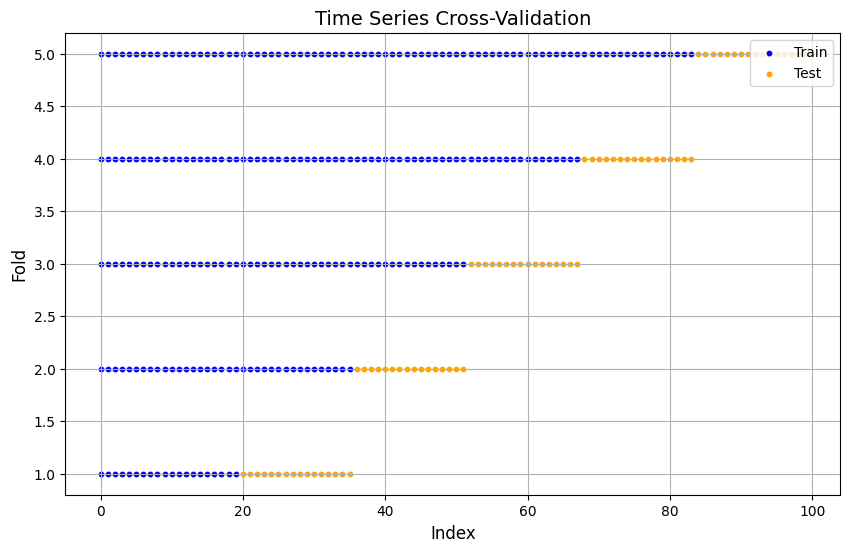

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Magalu):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [105]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
23701,2011-05-23,4.606467,4.641542,4.545086,4.641542,4.274923,935719,MGLU3.SA,-0.017537,4.668414,1.0,4.641542,1.0,4.881218,4.793972,0.017537,0.000000,32.626397,4.533395,4.878295,39.147243,-60.852757,-0.015200,-0.035350,-0.024154,-13212506
23702,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218391,3585840,MGLU3.SA,-0.061381,4.641938,1.0,4.580161,1.0,4.878295,4.819269,0.061381,0.000000,25.316822,4.533395,4.878295,31.470881,-68.529119,-0.018632,-0.032007,-0.024912,-16798346
23703,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091865,1985366,MGLU3.SA,-0.137376,4.582192,1.0,4.442785,1.0,4.846144,4.827331,0.137376,0.000000,16.037903,4.439862,4.822760,37.171802,-62.828198,-0.024626,-0.030531,-0.039459,-18783712
23704,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234543,1263135,MGLU3.SA,0.154913,4.586844,1.0,4.597698,1.0,4.998134,4.878572,0.000000,0.154913,43.149183,4.436940,4.822760,38.853271,-61.146729,-0.028604,-0.030145,-0.040231,-17520577
23705,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.596238,1.0,4.618158,1.0,5.012748,4.918825,0.000000,0.020460,45.815425,4.436940,4.822760,41.288139,-58.711861,-0.030707,-0.030258,-0.038254,-15742540


In [106]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.42
  Accuracy with Verify: 0.46
Window 2:
  Accuracy with Y_test (Prediction): 0.66
  Accuracy with Verify: 0.62
Window 3:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.48
Window 4:
  Accuracy with Y_test (Prediction): 0.30
  Accuracy with Verify: 0.29
Window 5:
  Accuracy with Y_test (Prediction): 0.18
  Accuracy with Verify: 0.24
Window 6:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.56
Window 7:
  Accuracy with Y_test (Prediction): 0.43
  Accuracy with Verify: 0.44
Window 8:
  Accuracy with Y_test (Prediction): 0.27
  Accuracy with Verify: 0.33
Window 9:
  Accuracy with Y_test (Prediction): 0.34
  Accuracy with Verify: 0.32
Window 10:
  Accuracy with Y_test (Prediction): 0.73
  Accuracy with Verify: 0.68
Window 11:
  Accuracy with Y_test (Prediction): 0.31
  Accuracy with Verify: 0.33
Window 12:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.38
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [ ]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [108]:
# Grab our X & Y Columns.
X_Cols = price_data_Magalu[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Magalu.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Magalu.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Magalu.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  78.1136638452237


In [109]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.747642,0.810742,0.777914,391.000000
Up Day,0.816377,0.754587,0.784267,436.000000
accuracy,0.781137,0.781137,0.781137,0.781137
macro avg,0.782009,0.782664,0.781091,827.000000
weighted avg,0.783879,0.781137,0.781263,827.000000


Accuracy: 0.781136638452237
Precision: 0.8163771712158809
Recall: 0.7545871559633027
Specificity: 0.8107416879795396


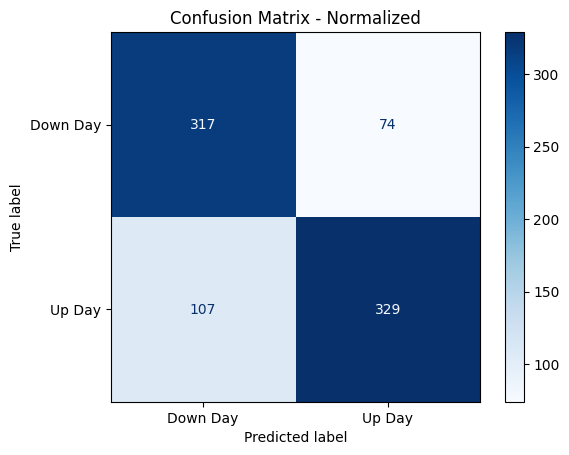

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


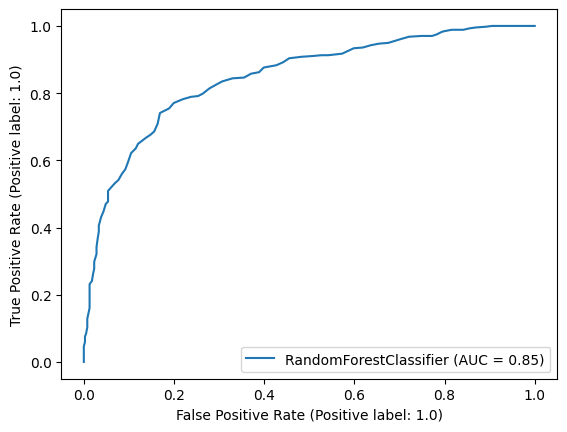

In [111]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [481]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [112]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 82.30%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

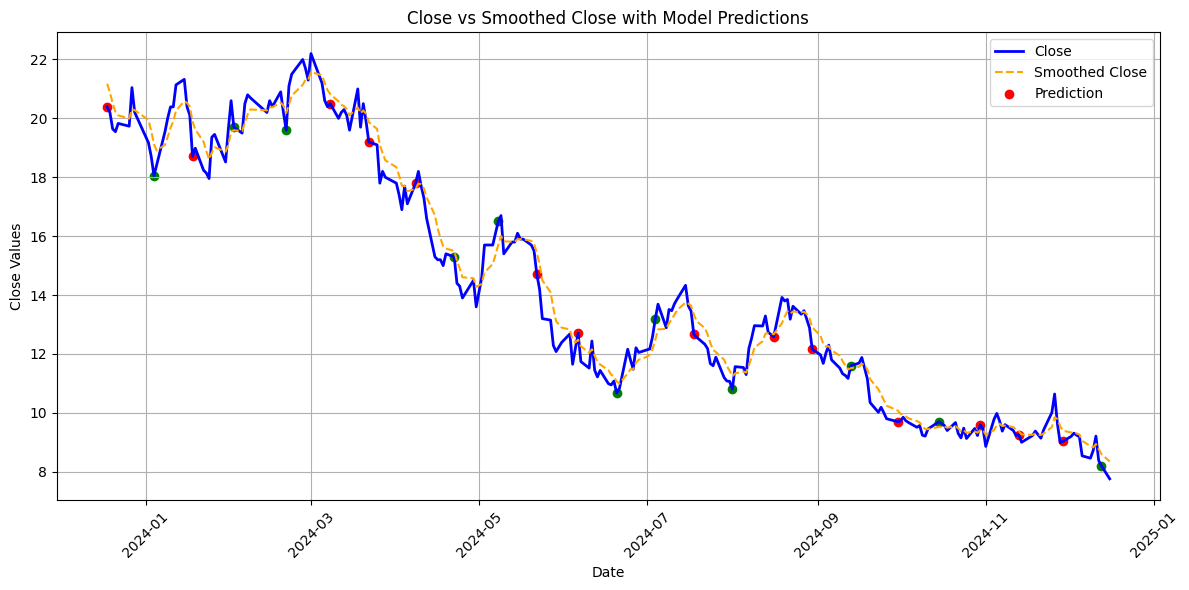

In [483]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Magalu.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [116]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
17835,2024-12-27,36.000000,36.000000,35.610001,35.660000,35.660000,24167200,PETR4.SA,-0.110001,36.518488,1.0,35.660000,1.0,36.820000,36.840772,0.110001,0.000000,20.526365,35.599998,40.759998,17.800177,-82.199823,-0.149991,0.221659,-0.074687,3100544117
17836,2024-12-30,35.779999,36.369999,35.770000,36.189999,36.189999,22355600,PETR4.SA,0.529999,36.419941,1.0,36.189999,1.0,37.290001,36.975540,0.000000,0.529999,32.377384,35.599998,40.759998,15.890357,-84.109643,-0.255279,0.126271,-0.067501,3078188517
17837,2025-01-02,36.419998,37.090000,36.189999,36.770000,36.770000,30046800,PETR4.SA,0.580002,36.524959,1.0,36.770000,1.0,37.049999,36.997878,0.000000,0.580002,43.092658,35.599998,40.759998,17.925587,-82.074413,-0.326482,0.035721,-0.056724,3108235317
17838,2025-01-03,36.880001,37.040001,36.320000,36.380001,36.380001,23314200,PETR4.SA,-0.389999,36.481471,1.0,36.380001,1.0,37.200001,37.058515,0.389999,0.000000,38.374848,35.599998,40.759998,17.082810,-82.917190,-0.382017,-0.047827,-0.054761,3084921117
17839,2025-01-06,36.599998,36.689999,36.060001,36.209999,36.209999,23760200,PETR4.SA,-0.170002,36.400030,1.0,36.209999,1.0,37.259998,37.118960,0.170002,0.000000,36.372025,35.599998,38.889999,24.317053,-75.682947,-0.427670,-0.123796,-0.047356,3061160917


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [118]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:


  Accuracy with Y_test (Prediction): 0.4831
  Accuracy with Verify: 0.4901
Fold 2:
  Accuracy with Y_test (Prediction): 0.4851
  Accuracy with Verify: 0.4812
Fold 3:
  Accuracy with Y_test (Prediction): 0.5675
  Accuracy with Verify: 0.5089
Fold 4:
  Accuracy with Y_test (Prediction): 0.4931
  Accuracy with Verify: 0.4593
Fold 5:
  Accuracy with Y_test (Prediction): 0.5496
  Accuracy with Verify: 0.4583

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5157
  Média da acurácia com Verify: 0.4796

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0    -1.0
2           -1.0              1.0    -1.0
3           -1.0              1.0    -1.0
4           -1.0             -1.0    -1.0
...          ...              ...     ...
5035         1.0              1.0     1.0
5036         1.0              1.0     1.0
5037         1.0              1.0     1.0
5038        -1.0              1.0     1.0
5039

#### Plotagem Time-Series Cross Validation

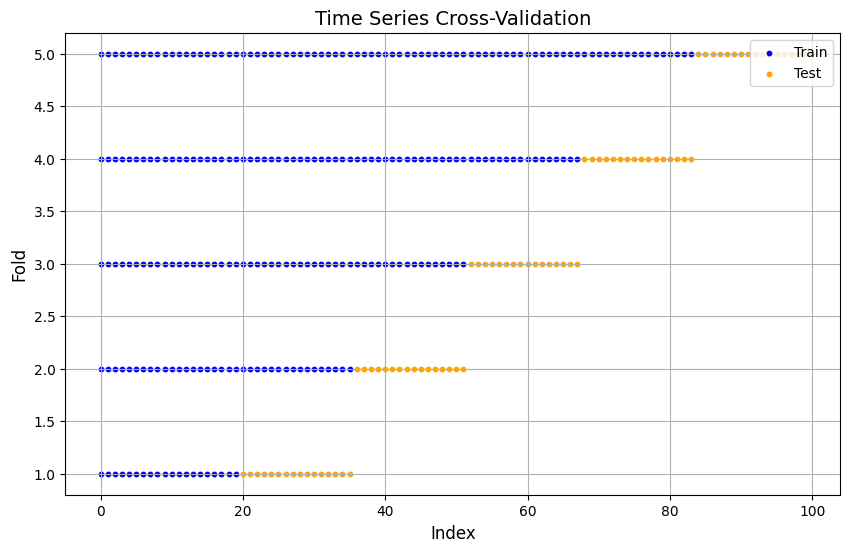

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Petro):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [109]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [110]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.67
Window 2:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.56
Window 3:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.47
Window 4:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.50
Window 5:
  Accuracy with Y_test (Prediction): 0.51
  Accuracy with Verify: 0.53
Window 6:
  Accuracy with Y_test (Prediction): 0.47
  Accuracy with Verify: 0.43
Window 7:
  Accuracy with Y_test (Prediction): 0.61
  Accuracy with Verify: 0.61
Window 8:
  Accuracy with Y_test (Prediction): 0.77
  Accuracy with Verify: 0.72
Window 9:
  Accuracy with Y_test (Prediction): 0.59
  Accuracy with Verify: 0.60
Window 10:
  Accuracy with Y_test (Prediction): 0.45
  Accuracy with Verify: 0.47
Window 11:
  Accuracy with Y_test (Prediction): 0.39
  Accuracy with Verify: 0.30
Window 12:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.51
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [111]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [112]:
# Grab our X & Y Columns.
X_Cols = price_data_Petro[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Petro.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Petro.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Petro.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  74.10832232496698


In [113]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.718400,0.675188,0.696124,665.000000
Up Day,0.757030,0.792697,0.774453,849.000000
accuracy,0.741083,0.741083,0.741083,0.741083
macro avg,0.737715,0.733943,0.735289,1514.000000
weighted avg,0.740063,0.741083,0.740048,1514.000000


Accuracy: 0.7410832232496698
Precision: 0.7570303712035995
Recall: 0.7926972909305064
Specificity: 0.675187969924812


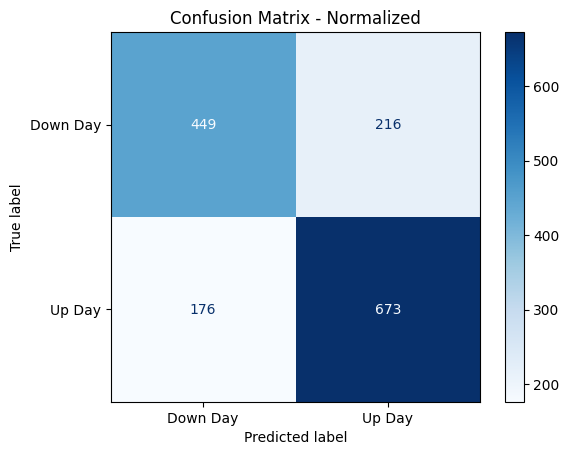

In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


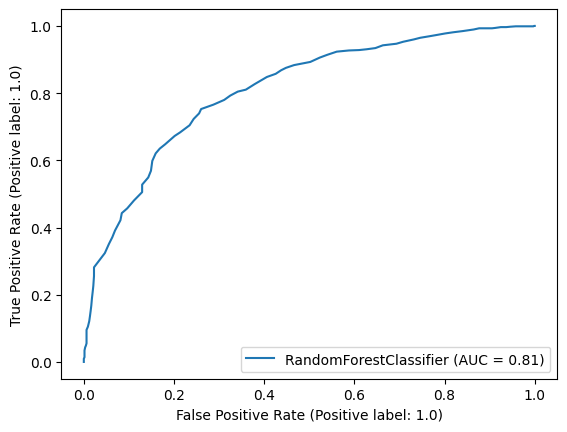

In [115]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [492]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [124]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.75%

Precisão do modelo nos últimos 30 dias: 89.47%


#### Plotagem:

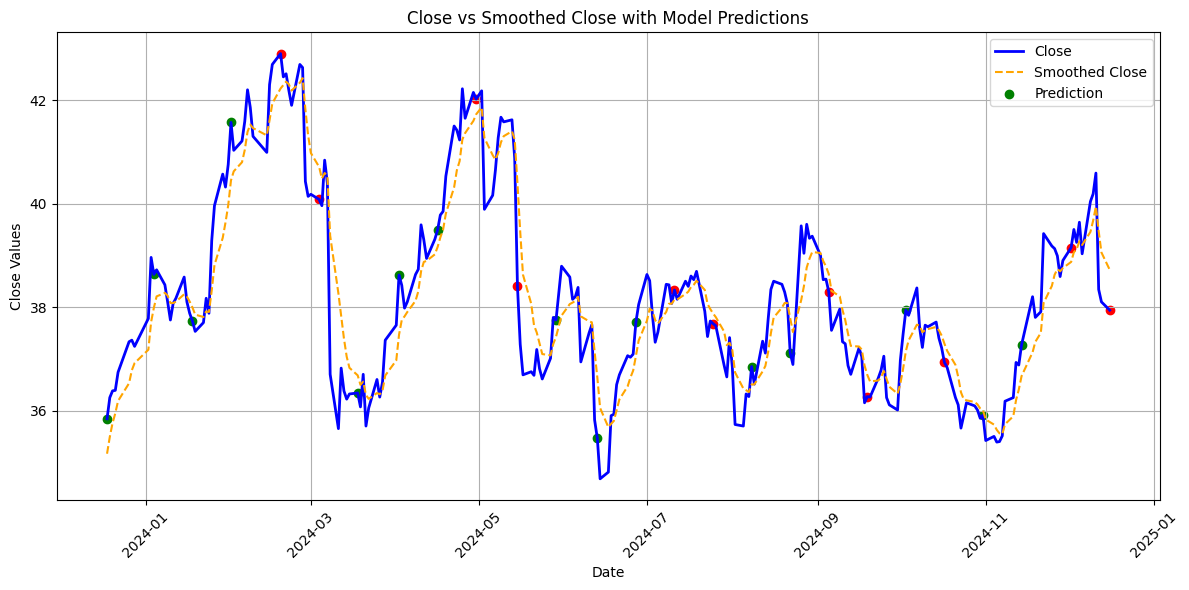

In [494]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Petro.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [36]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
5759,2000-01-21,4.000000,4.000000,3.916666,3.916666,1.611243,144000,VALE3.SA,-0.083334,3.977111,1.0,3.916666,1.0,4.000000,4.075896,0.083334,0.000000,55.357618,3.375000,4.166666,76.056147,-23.943853,0.060975,0.029227,0.108471,19603200
5760,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.631812,196800,VALE3.SA,0.050000,3.973977,1.0,3.966666,-1.0,3.790833,3.990377,0.000000,0.050000,60.156173,3.375000,4.166666,75.660348,-24.339652,0.060140,0.035409,0.084587,19406400
5761,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.645525,211200,VALE3.SA,0.033334,3.981784,-1.0,4.000000,-1.0,3.741666,3.915764,0.000000,0.033334,63.199074,3.375000,4.166666,76.646473,-23.353527,0.059224,0.040172,0.067908,19617600
5762,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.611243,148800,VALE3.SA,-0.083334,3.962249,-1.0,3.916666,-1.0,3.833333,3.891035,0.083334,0.000000,51.789901,3.458333,4.166666,71.141066,-28.858934,0.056581,0.043454,0.039276,19468800
5763,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.542679,739200,VALE3.SA,-0.166666,3.898574,-1.0,3.750000,1.0,3.833333,3.873724,0.166666,0.000000,36.559368,3.750000,4.166666,35.657831,-64.342169,0.049848,0.044733,0.001238,18729600


In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Specify the number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Store results
fold = 1
report_dict = {}

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Split data into train and test sets for the current fold
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Train the model
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Generate the classification report
    target_names = ['Down Day', 'Up Day']  # Assuming these are your target names
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Flatten the report and convert it into a DataFrame
    report_flat = pd.DataFrame(report).transpose()
    
    # Add a column with the accuracy for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    report_flat['accuracy'] = accuracy
    
    # Store the report for this fold in the dictionary
    report_dict[fold] = report_flat
    
    # Display fold accuracy
    print(f"Accuracy for fold {fold}: {accuracy:.2f}\n")
    
    fold += 1

# Now concatenate the reports from all folds
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Display the final report DataFrame
print(final_report_df)


In [37]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.3900
  Accuracy with Verify: 0.4300
Fold 2:
  Accuracy with Y_test (Prediction): 0.5490
  Accuracy with Verify: 0.4770
Fold 3:
  Accuracy with Y_test (Prediction): 0.5360
  Accuracy with Verify: 0.5000
Fold 4:
  Accuracy with Y_test (Prediction): 0.5470
  Accuracy with Verify: 0.4760
Fold 5:
  Accuracy with Y_test (Prediction): 0.5610
  Accuracy with Verify: 0.4950

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5166
  Média da acurácia com Verify: 0.4756

Comparação:
      Prediction  Y_Test (Actual)  Verify
0           -1.0              1.0     1.0
1           -1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
4995         1.0             -1.0    -1.0
4996         1.0             -1.0    -1.0
4997         1.0             -1.0    -1.0
4998         1.0             -1.0     

#### Plotagem Time-Series Cross Validation

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# Define the plotting function for cross-validation splits
def plot_cross_val(n_splits, splitter_func, df, title_text):
    """
    Plot the splits for Time Series Cross-Validation.
    
    Args:
    - n_splits: Number of splits for cross-validation.
    - splitter_func: Cross-validation splitter (e.g., TimeSeriesSplit).
    - df: The dataset (DataFrame or array-like).
    - title_text: Title for the plot.
    """
    tscv = splitter_func(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Iterate through splits and plot train/test indices
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        ax.scatter(train_idx, [i + 1] * len(train_idx), color="blue", label="Train" if i == 0 else "", s=10)
        ax.scatter(test_idx, [i + 1] * len(test_idx), color="orange", label="Test" if i == 0 else "", s=10)
    
    ax.set_title(title_text, fontsize=14)
    ax.set_xlabel("Index", fontsize=12)
    ax.set_ylabel("Fold", fontsize=12)
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()

# Simulated example dataset
data = np.arange(100)  # Replace with your actual dataset or DataFrame index

# Plot the time series cross-validation splits
plot_cross_val(
    n_splits=5,
    splitter_func=TimeSeriesSplit,
    df=data,
    title_text="Time Series Cross-Validation"
)


#### Walk-Forward Validation

In [ ]:
# Import packages
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define rolling window sizes
train_window = 365  # Tamanho da janela de treinamento (ex.: 100 períodos)
test_window = 180    # Tamanho da janela de teste (ex.: 20 períodos)

# Grab our X & Y Columns
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Store results for evaluation
accuracies = []

# Perform Walk-Forward Validation with Rolling Windows
start = 0  # Índice inicial
while start + train_window + test_window <= len(price_data_Vale):
    # Define train and test indices
    train_index = list(range(start, start + train_window))
    test_index = list(range(start + train_window, start + train_window + test_window))
    
    # Split data into train and test sets
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    
    # Create and fit the Random Forest Classifier
    rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Evaluate accuracy for the current split
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Window {start // test_window + 1} Accuracy: {acc:.4f}")
    
    # Move the window forward
    start += test_window

# Print overall results
print("\nWalk-Forward Validation with Rolling Windows Results:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Standard Deviation: {np.std(accuracies):.4f}")


In [27]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.2f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.2f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.2f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.2f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.53
Window 2:
  Accuracy with Y_test (Prediction): 0.56
  Accuracy with Verify: 0.56
Window 3:
  Accuracy with Y_test (Prediction): 0.44
  Accuracy with Verify: 0.48
Window 4:
  Accuracy with Y_test (Prediction): 0.44
  Accuracy with Verify: 0.48
Window 5:
  Accuracy with Y_test (Prediction): 0.52
  Accuracy with Verify: 0.57
Window 6:
  Accuracy with Y_test (Prediction): 0.69
  Accuracy with Verify: 0.67
Window 7:
  Accuracy with Y_test (Prediction): 0.39
  Accuracy with Verify: 0.37
Window 8:
  Accuracy with Y_test (Prediction): 0.53
  Accuracy with Verify: 0.49
Window 9:
  Accuracy with Y_test (Prediction): 0.34
  Accuracy with Verify: 0.35
Window 10:
  Accuracy with Y_test (Prediction): 0.57
  Accuracy with Verify: 0.48
Window 11:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.54
Window 12:
  Accuracy with Y_test (Prediction): 0.58
  Accuracy with Verify: 0.58
Window 13:
  Accuracy wit

#### Split normal sem cross-validation.

In [29]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [30]:
# Grab our X & Y Columns.
X_Cols = price_data_Vale[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf_Vale.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf_Vale.predict(X_test)
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf_Vale.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  73.30226364846871


In [31]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.724191,0.679191,0.700969,692.000000
Up Day,0.739742,0.779012,0.758870,810.000000
accuracy,0.733023,0.733023,0.733023,0.733023
macro avg,0.731967,0.729102,0.729919,1502.000000
weighted avg,0.732577,0.733023,0.732194,1502.000000


Accuracy: 0.7330226364846871
Precision: 0.7397420867526378
Recall: 0.7790123456790123
Specificity: 0.6791907514450867


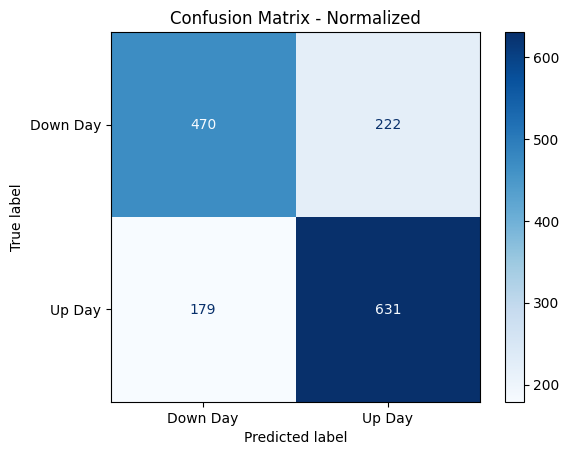

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculando a matriz de confusão
rf_matrix = confusion_matrix(y_test, y_pred)

# Extraindo os valores da matriz de confusão
true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

# Calculando as métricas
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Imprimindo as métricas
print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(precision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

# Criando o display da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels=['Down Day', 'Up Day'])

# Plotando a matriz de confusão com a normalização
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Adicionando título
plt.title('Confusion Matrix - Normalized')

# Exibindo o gráfico
plt.show()


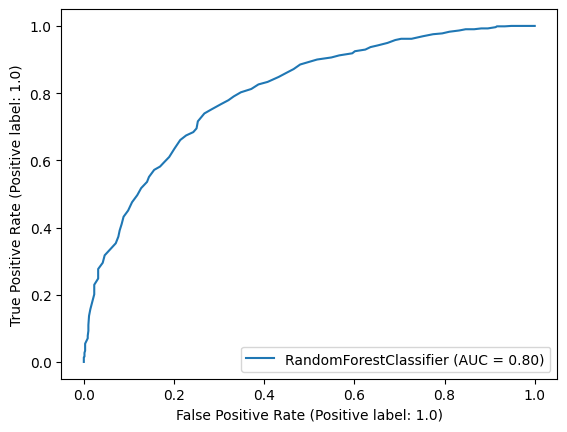

In [33]:

# Create an ROC Curve plot
rfc_disp = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [504]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [34]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 80.63%

Precisão do modelo nos últimos 30 dias: 82.35%


#### Plotagem:

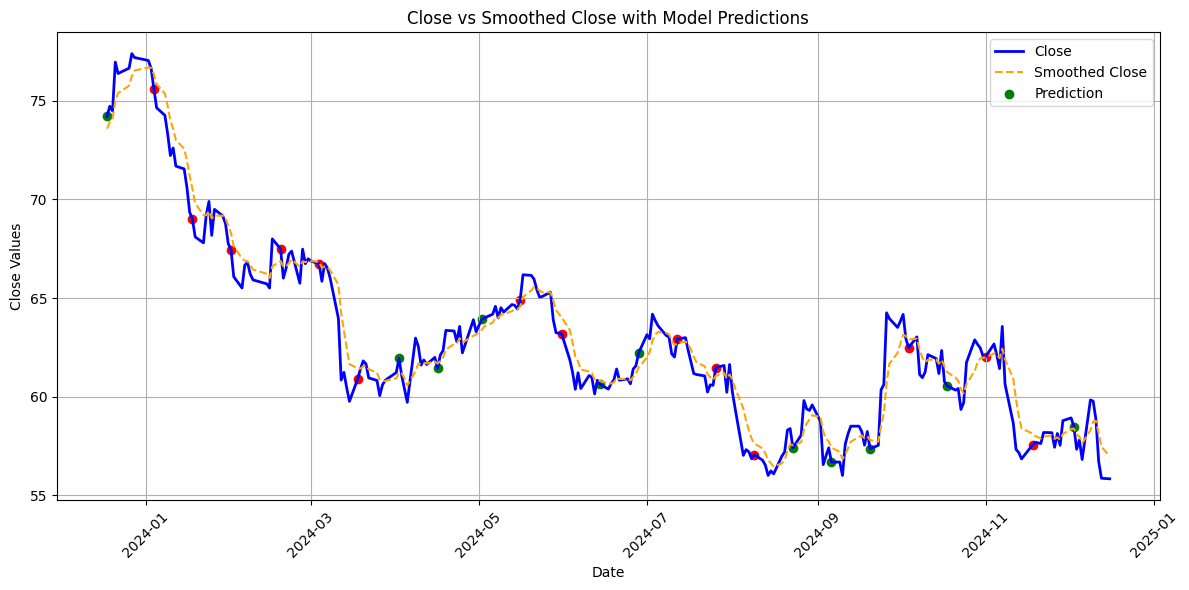

In [506]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Vale.predict(X_Cols)

# Agora, vamos plotar o gráfico com as previsões do modelo
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Close", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
for i in range(0, len(one_year_data), 10):  # A cada 10 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label="Prediction" if i == 0 else "")

# Configurações finais do gráfico
plt.xlabel("Date")
plt.ylabel("Close Values")
plt.title("Close vs Smoothed Close with Model Predictions")
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotaciona as datas para facilitar a leitura
plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
